In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datetime import datetime
import random
import sklearn.metrics as metrics
import pickle
import json

In [3]:
def get_vecmap(path):
    dic = dict()
    with open(path) as f:
        vec = f.readlines()
        for line in vec[1:]:
            items = line.split()
            dic[items[0]] = [float(item) for item in items[1:]]
    print("{} unique instructions in total. ".format(len(dic)))
    return dic

In [4]:
def get_dict(p):
    dic = dict()
    with open(p) as file:
        lines = [line.rstrip() for line in file]
    for line in lines[1:]:
        token = line.split()[0]
        vec = line.split()[1:]
        dic[token] = [float(v) for v in vec]
    return dic

In [5]:
def load_pkl(p):
    with open(p,'rb') as pkl_file:
        f_out = pickle.load(pkl_file)
    return f_out

In [6]:
target = 'mips'

In [7]:
# read the vectors into a dictionary

path_x86_vec = '/home/joey/opt/unimap/mappers/x86_armx86_200.emb'
dict_x86 = get_vecmap(path_x86_vec)

path_target_vec = f'/home/joey/opt/unimap/mappers/{target}_{target}x86_200_identical.emb'
dict_target = get_vecmap(path_target_vec)


40781 unique instructions in total. 
44924 unique instructions in total. 


In [8]:
EMB_DIM = 200
MAX_LEN = 10000

In [9]:
x86_benign = '/home/joey/opt/unimap/malware/train_benign.pkl' 
x86_malware = '/home/joey/opt/unimap/malware/x86_mal_add.json' 

target_benign = f'/home/joey/opt/unimap/malware/{target}_benign.pkl'
target_malware = f'/home/joey/opt/unimap/malware/malware_{target}.json'

In [10]:
# read benign dataset in x86
x86_dataset_benign = load_pkl(x86_benign)
# read malware dataset in x86
x86_dataset_malware = load_json(x86_malware)


In [11]:
print("{} benign files and {} malware files in total for x86".format(len(x86_dataset_benign), len(x86_dataset_malware)))

3541 benign files and 618 malware files in total for x86


In [12]:
# read benign dataset in target arch
target_dataset_benign = load_pkl(target_benign)
# read malware dataset in x86
target_dataset_malware = load_json(target_malware)
print("{} benign files and {} malware files in total for {}".format(len(target_dataset_benign), len(target_dataset_malware), target))

819 benign files and 570 malware files in total for mips


In [13]:
# random.shuffle(x86_dataset_benign)
# random.shuffle(x86_dataset_malware)
random.shuffle(target_dataset_benign)
random.shuffle(target_dataset_malware)

In [14]:
# build the dataset
training_size = 618
testing_size = 500

x86_training_set = x86_dataset_benign[:training_size] + x86_dataset_malware[:training_size]
x86_training_labels = [0] * training_size + [1] * training_size

target_testing_set = target_dataset_benign[:testing_size] + target_dataset_malware[:testing_size]
target_testing_labels = [0] * testing_size + [1] * testing_size

In [15]:
X_train, X_test, y_train, y_test = train_test_split(x86_training_set, x86_training_labels, test_size=0.2, random_state=42)

# BE CAREFUL! DO NOT OVERWRITE!

In [25]:
def data_generator(X, y, dic, batch_size=16):
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        end = min((i + 1) * batch_size, len(y))
        
        X_batch = X[i * batch_size:end]
        y_batch = y[i * batch_size:end]

        for j in range(len(X_batch)):
            x = X_batch[j]
            para_vec = []
            for inst in x[:MAX_LEN]:
                try:
                    para_vec.append(dic[inst])
                except KeyError:
                    # print('unknown word!')
                    para_vec.append([0] * 200)
                
            if len(x) < MAX_LEN:
                pad =  [[0] * EMB_DIM] * (MAX_LEN - len(x))
                X_batch[j] = pad + para_vec
            else:
                X_batch[j] = para_vec
        
        X_batch = torch.from_numpy(np.array(X_batch)).float()      
        y_batch = torch.from_numpy(np.array(y_batch)).float()
        yield X_batch, y_batch

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [27]:
# Define the model
class RNN(nn.Module):
    # embed_dim is 100 in our case
    # n_hidden: the dimension of each hidden layer
    # n_rnnlayers: the number of layers
    def __init__(self, embed_dim, n_hidden, n_rnnlayers, n_outputs):
        super(RNN, self).__init__()
        self.D = embed_dim
        self.M = n_hidden
        self.K = n_outputs
        self.L = n_rnnlayers
        
        self.rnn = nn.LSTM(
            input_size = self.D,
            hidden_size = self.M, 
            num_layers = self.L,
            batch_first = True)
        
        self.fc = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        # initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
        c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

 
        # get RNN unit output
        out, _ = self.rnn(X, (h0, c0))
        
        # max pool
        out, _ = torch.max(out, 1)
        
        # we only want h(T) at the final time step
        out = self.fc(out)
        return out   

In [28]:
model = RNN(EMB_DIM, 8, 2, 1)
model.to(device)

RNN(
  (rnn): LSTM(200, 8, num_layers=2, batch_first=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)

In [29]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [30]:
len(X_train)

988

In [32]:
train_gen = lambda: data_generator(X_train, y_train, dict_x86, batch_size=16)
test_gen = lambda: data_generator(X_test, y_test, dict_x86, batch_size=16)
test_cross_gen = lambda: data_generator(target_testing_set, target_testing_labels, dict_target, batch_size=16)

In [34]:
def batch_gd(model, criterion, optimizer, epochs):
    train_losses = np.zeros(epochs)
    train_accs = np.zeros(epochs)
    
    test_losses = np.zeros(epochs) 
    test_accs = np.zeros(epochs)
    
    test_cross_losses = np.zeros(epochs)
    test_cross_accs = np.zeros(epochs)
    
    for it in range(epochs):
        print('Training on epoch {}'.format(it + 1))
        t0 = datetime.now()
        train_loss = []   
        n_correct = 0
        n_total = 0
        for inputs, targets in train_gen():
            targets = targets.view(-1, 1).float()
            # move data to GPU
            inputs, targets = inputs.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_loss.append(loss.item()) 
            
            # backward and optimize
            loss.backward()
            optimizer.step()
            
            # Train acc
            predictions = outputs.reshape(-1).round()
            targets = targets.reshape(-1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]   
              
        train_loss = np.mean(train_loss)
        train_acc = n_correct / n_total
        
        
        # Get test loss and acc
        n_correct = 0.
        n_total = 0.
        test_loss = []
        for inputs, targets in test_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # test loss
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
            # test acc
            predictions = outputs.reshape(-1).round()
            targets = targets.reshape(-1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]  
        test_loss = np.mean(test_loss)
        test_acc = n_correct / n_total
        
        # cross testing
        n_correct = 0.
        n_total = 0.
        test_cross_loss = []
        for inputs, targets in test_cross_gen():
            targets = targets.view(-1, 1).float()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # test loss
            loss = criterion(outputs, targets)
            test_cross_loss.append(loss.item())
            # test acc
            predictions = outputs.reshape(-1).round()
            targets = targets.reshape(-1)
            n_correct += (predictions == targets).sum().item()
            n_total += targets.shape[0]  
        test_cross_loss = np.mean(test_cross_loss)
        test_cross_acc = n_correct / n_total
        
        # save everything!!!
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        train_accs[it] = train_acc
        test_accs[it] = test_acc
        test_cross_losses[it] = test_cross_loss
        test_cross_accs[it] = test_cross_acc
                
        dt = datetime.now() - t0
        
        torch.save(model.state_dict(), 'lstm_x86_mips_it{}_99.pt'.format(it))
        
        print(f'Epoch {it}/{epochs},  Duration: {dt}')
        print(f'Train Loss: {train_loss:.4f},     Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f},       Test Acc: {test_acc:.4f}')
        print(f'Test CROSS Loss: {test_cross_loss:.4f},       Test CROSS ACC: {test_cross_acc:.4f}') 
        
#     return train_losses, test_losses, train_accs, test_accs
    return train_losses, test_losses, train_accs, test_accs, test_cross_losses, test_cross_accs  

In [35]:
"""
max_len: 10000
"""
train_losses, test_losses, train_accs, test_accs, test_cross_losses, test_cross_accs  = batch_gd(model, criterion, optimizer, 10)

Training on epoch 1
Epoch 0/10,  Duration: 0:05:16.109544
Train Loss: 0.6832,     Train Acc: 0.4919
Test Loss: 0.6590,       Test Acc: 0.5323
Test CROSS Loss: 0.6541,       Test CROSS ACC: 0.5000
Training on epoch 2
Epoch 1/10,  Duration: 0:05:13.115958
Train Loss: 0.5962,     Train Acc: 0.7308
Test Loss: 0.5263,       Test Acc: 0.8871
Test CROSS Loss: 0.4575,       Test CROSS ACC: 1.0000
Training on epoch 3
Epoch 2/10,  Duration: 0:05:17.184892
Train Loss: 0.4673,     Train Acc: 0.6103
Test Loss: 1.0238,       Test Acc: 0.0040
Test CROSS Loss: 0.9559,       Test CROSS ACC: 0.0000
Training on epoch 4
Epoch 3/10,  Duration: 0:05:16.068383
Train Loss: 0.6646,     Train Acc: 0.4200
Test Loss: 0.4577,       Test Acc: 0.3226
Test CROSS Loss: 0.3491,       Test CROSS ACC: 0.5000
Training on epoch 5
Epoch 4/10,  Duration: 0:05:14.478633
Train Loss: 0.4556,     Train Acc: 0.3492
Test Loss: 0.4051,       Test Acc: 0.2218
Test CROSS Loss: 0.2985,       Test CROSS ACC: 0.4960
Training on epoch 6


In [36]:
# test x86 
n_correct = 0.
n_total = 0.
probs_np = np.array([])
y_np = np.array([])

for inputs, targets in test_gen():
    inputs = inputs.to(device)
    # make prediction
    outputs = model(inputs)
    # to numpy array
    preds = outputs.cpu().detach().numpy()
    probs_np = np.append(probs_np, preds)
    y_np = np.append(y_np, targets.detach().numpy())
    
fpr1, tpr1, threshold = metrics.roc_curve(y_np, probs_np)
roc_auc1 = metrics.auc(fpr1, tpr1)

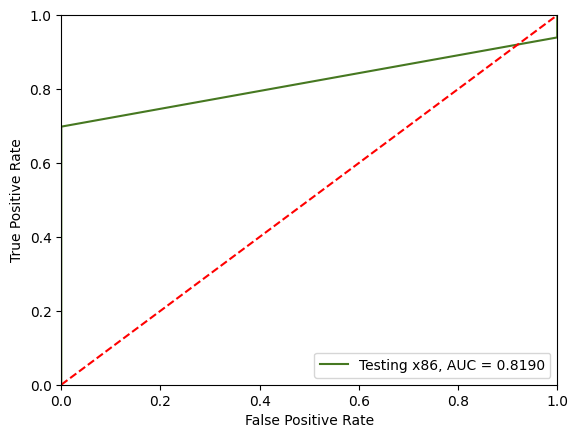

In [37]:
plt.plot(fpr1, tpr1, '#467821', label = 'Testing x86, AUC = %0.4f' % roc_auc1) # x86
# plt.plot(fpr, tpr, '#7A68A6', label = 'Testing MIPS, AUC = %0.4f' % roc_auc) # ppc

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('test_x86.png')

In [39]:
len(fpr1)

12

In [41]:
len(y_np)

248

In [42]:
probs_np

array([-0.73879123, -0.73777241, -0.73777241, -0.73777241,  2.41329479,
       -0.73777241,  2.45449734,  2.42841339, -0.73777241, -0.73777241,
        2.4094429 ,  2.44243717, -0.73777241,  2.66186976, -0.73777241,
       -0.73777241, -0.73777241, -0.73777241, -0.73777241, -0.73777241,
        2.46134424, -0.73777241, -0.73777241, -0.73777241, -0.73777241,
        2.30142331, -0.73777241,  2.38059211, -0.73777241, -0.73777241,
        2.8203845 , -0.73777241, -0.73777241,  2.43527651, -0.73777241,
       -0.73777241,  2.89430714, -0.73777241, -0.73777241, -0.73777241,
       -0.73869616, -0.73777241,  2.66374969, -0.73777241, -0.73777241,
       -0.73777241,  2.8203845 ,  2.66374969, -0.50406343,  2.42250156,
        2.83213282, -0.73777241, -0.73777241,  2.66374969, -0.73777241,
        2.46322274, -0.73777241, -0.73777241, -0.73777241,  2.44062901,
        2.45907784,  2.44399405, -0.73777241, -0.73869616,  2.4503417 ,
       -0.73777241, -0.73777241,  2.46463394, -0.73777241, -0.73

In [25]:
# load trained model
model.load_state_dict(torch.load('gru_x86_mips_it8_99.pt'))

<All keys matched successfully>

In [26]:
testing_size = 500

target_testing_set = target_dataset_benign[:testing_size] + target_dataset_malware[:testing_size]
target_testing_labels = [0] * testing_size + [1] * testing_size
test_cross_gen = lambda: data_generator(target_testing_set, target_testing_labels, dict_target, batch_size=16)

In [29]:
# test target  arch
n_correct = 0.
n_total = 0.
probs_np = np.array([])
y_np = np.array([])

for inputs, targets in test_cross_gen():
    inputs = inputs.to(device)
    # make prediction
    outputs = model(inputs)
    # to numpy array
    preds = outputs.cpu().detach().numpy()
    probs_np = np.append(probs_np, preds)
    y_np = np.append(y_np, targets.detach().numpy())
    
fpr, tpr, threshold = metrics.roc_curve(y_np, probs_np)
roc_auc = metrics.auc(fpr, tpr)

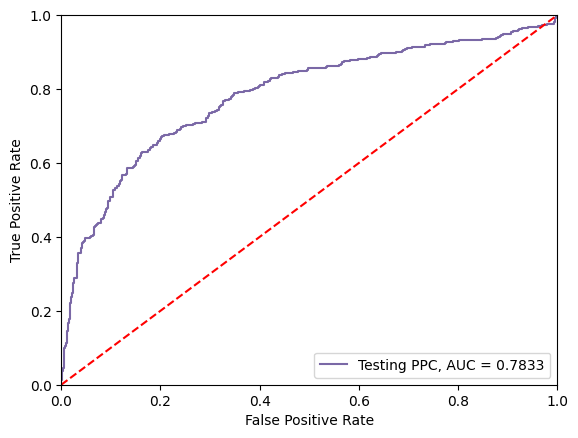

In [30]:
# plt.plot(fpr1, tpr1, '#467821', label = 'Testing x86, AUC = %0.4f' % roc_auc1) # x86
plt.plot(fpr, tpr, '#7A68A6', label = 'Testing PPC, AUC = %0.4f' % roc_auc) # ppc

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('test_ppc_99_epoch8.png')

In [31]:
y_np[:10]

array([0., 0., 0., 1., 0., 1., 0., 0., 1., 1.])

In [32]:
probs_np[:10]

array([0.06030525, 0.00103085, 0.99749279, 0.98418725, 0.98893654,
       0.99537116, 0.00107152, 0.98418623, 0.83221555, 0.99782616])

In [6]:
dict_x86.keys()

dict_keys(['MOV', 'LOC_<TAG>', '<FOO>', 'CALL', 'SHORT', 'LEA', 'TEST', 'JZ', 'RAX,[RBP+<TAG>]', 'PUSH', 'CMP', 'JMP', 'ADD', 'XOR', 'JNZ', 'EAX,0', 'EAX,EAX', 'POP', 'RDI,RAX', 'RSP,0', 'SUB', 'RBP', 'MOVZX', 'RETN', 'EDX,0', 'ESI,0', '[RBP+<TAG>],0', 'RAX,RAX', 'RBX', 'RAX,[RAX+0]', '[RBP+<TAG>],RAX', 'EDI,0', 'R12', 'AND', 'RAX,0', 'RAX,[RBP+0]', 'RDX,[RBP+<TAG>]', 'EAX,[RBP+<TAG>]', 'RSI,<TAG>', 'R8D,0', 'SHR', 'R13', 'RCX,<TAG>', 'RDI,RBP', '<DWORD_PTR>', 'RDI,<TAG>', 'RBP,RSP', 'SHL', 'EAX,<BYTE_PTR>', 'LOCRET_<TAG>', '<BYTE_PTR>', '<QWORD_PTR>', 'ECX,0', 'R14', '<TAG>', 'RDX,[RAX+0]', 'RAX,RDX', 'OR', 'RAX,FS:<ADDR>', 'RDX,RAX', 'RAX,<TAG>', 'EDX,EAX', 'R15', 'MOVSXD', '[RBP+<TAG>],EAX', 'RAX,[RAX]', 'RDI,RBX', 'EAX,[RAX+0]', 'LEAVE', 'EAX,AL', '[RBP+<TAG>],RDI', 'RDI,R12', '[RAX+0],0', '[RSP+0+<TAG>],0', 'RCX,[RBP+<TAG>]', 'AL,0', 'RAX', 'RSI,RDX', 'RDI,[RSP+0+<TAG>]', 'JLE', '[RAX]', 'EAX,EDX', 'RDX,<TAG>', 'RDX,0', '[RSP+0+<VAR>],RAX', 'RSI,RAX', '[RBP+<TAG>],RDX', '[RBP+<TAG